# 2018-11-20 Protein Trap Scoring

As a group we need to define the "success" condition. In other words, **What does validated mean?**

Possible definitions of when a sample is validated:
* If protein expression is **highest** in the cell type(s) where that gene is a biomarker.
* If protein expression is in the **top 50%** in the cell type(s) where that gene is a biomarker.
* If protein expression is expressed **at all** in the cell type(s) where that gene is a biomarker.
* For samples with lineages
    * If protein expression comes on after the earliest RNA-expression

Major complications:
* Most of the protein trap scores are based on a single image.
* Absence of a evidence is not evidence of absence. Is a 0 in a protein trap really NA? 
* Protein expression may be delayed compared to RNA expression, therefore looking at neighboring cell stages may be necessary.

In [1]:
# import needed packages
import os
import sys
import re
from pathlib import Path
from functools import partial

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.normalization import tpm

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force')

last updated: 2018-11-20 
Git hash:


# Data Description

Protein trap scores are based on scores found in the "No. Scale All" worksheet [here](https://docs.google.com/spreadsheets/d/1bonAl5A87UauynDxwClbOkbqqHHr684seOrXNIf5fLk/edit?usp=sharing). For genes with multiple ptraps I averaged their scores.

Since we only have 1 Cyst category I re aggregated scRNA-Seq expression data
* Sum raw reads for all Cyst cells
* Calcualte TPM using entire data set
* Pull out only the genes that we have a protein trap for

## Protein Trap Table

In [21]:
# aggregated protein traps
ptrap = pd.read_parquet('../output/paper_submission/ptrap_scores.parquet')
ptrap.index = ptrap.index.droplevel('gene_symbol')
ptrap_fbgn = ptrap.index.get_level_values('FBgn').tolist()

ptrap

,Spermatogonia,Early 1º Spermatocytes,Mid 1º Spermatocytes,Late 1º Spermatocytes,Cyst Cells,Pigment Cells,Terminal Epithelium
FBgn,,,,,,,
FBgn0000416,3.125000,3.750000,3.750000,5.000000,5.833333,2.500000,6.875000
FBgn0000636,0.312500,0.937500,0.625000,1.250000,1.250000,0.625000,5.104167
FBgn0002945,1.250000,2.500000,3.333333,1.666667,1.875000,0.833333,1.250000
FBgn0003475,0.000000,0.625000,1.250000,1.250000,0.833333,0.000000,0.000000
FBgn0004885,0.625000,1.666667,1.875000,1.875000,0.833333,0.000000,1.875000
FBgn0010473,0.000000,0.625000,0.625000,0.625000,0.625000,0.000000,1.250000
FBgn0011206,0.000000,0.625000,2.500000,6.875000,0.000000,0.000000,0.000000
FBgn0011725,0.833333,0.833333,0.833333,0.833333,0.000000,0.000000,0.000000
FBgn0012037,1.250000,1.875000,3.333333,3.750000,4.166667,0.000000,0.000000


## Expression Table

In [4]:
# Aggregate cyst cells and convert to TPM
raw = pd.read_parquet('../output/scrnaseq-wf/raw_by_cluster.parquet', columns=nbconfig.sel_cluster_order)
raw['Cyst Cells'] = raw[nbconfig.sel_cluster_order[4:7]].sum(axis=1)
raw = raw.reindex(columns=ptrap.columns)
gene_lens = pd.read_csv('../output/gene_ts_lengths.tsv', sep='\t', index_col=0).gene_ts_length
_tpm = tpm(raw, gene_length=gene_lens).dropna()
_tpm = _tpm.reindex(ptrap_fbgn)

_tpm

,Spermatogonia,Early 1º Spermatocytes,Mid 1º Spermatocytes,Late 1º Spermatocytes,Cyst Cells,Pigment Cells,Terminal Epithelium
FBgn,,,,,,,
FBgn0000416,109.300709,134.890833,68.163613,109.584111,383.001011,998.163861,298.592690
FBgn0000636,0.105420,0.313049,0.446051,0.440536,0.866881,1.343180,17.864569
FBgn0002945,1.479588,0.522998,0.485135,1.340689,10.430403,200.288106,12.417543
FBgn0003475,0.743671,5.739676,10.278157,7.486232,1.138886,0.722037,0.909867
FBgn0004885,0.064632,0.626525,1.053354,0.674760,0.149016,16.004981,0.245729
FBgn0010473,0.003204,0.035908,0.041714,0.017041,0.020493,0.019265,2.107483
FBgn0011206,11.803702,81.746948,124.280545,98.617208,13.935754,9.922324,9.759812
FBgn0011725,96.342161,896.409527,1788.786409,1359.193537,157.937722,155.405126,147.676601
FBgn0012037,1.092713,7.904953,12.611597,10.382603,3.355629,0.910471,1.073634


# Biomarker Information

We selected protein traps based on Replicate 1's biomarker list. To get an better understanding about where in the biomarker list a protein trap falls I have numbered protein traps (sorted by p_val_adj) with an incremental number (rank). Therefore a rank 1 is the "most" significant gene for that cluster and a large number means that gene falls lower on the list. However, all genes are significant, so we would hope anywhere on the list should validate.


There are three protein traps that are not in the current biomarker list:
* FBgn0015609 (CadN)
* FBgn0031518 (CG3277)
* FBgn0051158 (Efa6)

In [5]:
# Get biomarkers in the protein trap list
biomarkers = nbconfig.seurat.get_biomarkers('res.0.6')

# remove unknown clusters
biomarkers = biomarkers.query('cluster != 9 & cluster != 10 & cluster != 11')

# For each gene add "rank" based on locatin in sorted biomarker list for each cluster.
biomarkers_w_ranks = []
for g, dd in biomarkers.sort_values(by=['cluster', 'p_val_adj', 'avg_logFC']).groupby('cluster'):
    _curr = dd.copy()
    _curr['rank'] = range(1, _curr.shape[0] + 1)
    biomarkers_w_ranks.append(_curr)

biomarkers_w_ranks = pd.concat(biomarkers_w_ranks)

biomarkers_w_ranks = biomarkers_w_ranks[biomarkers_w_ranks.index.isin(ptrap_fbgn)].copy()
biomarkers_w_ranks.cluster = biomarkers_w_ranks.cluster.map(lambda x: nbconfig.cluster_annot[x])

biomarkers_w_ranks

,gene_symbol,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,rank
FBgn,,,,,,,,
FBgn0011725,twin,9.823702e-157,0.795192,0.671,0.484,1.422079e-152,Late 1º Spermatocytes,69
FBgn0032771,CG17349,7.907477e-54,0.594297,0.466,0.371,1.144686e-49,Late 1º Spermatocytes,236
FBgn0030520,Pdcd4,3.880065e-61,0.460794,0.714,0.600,5.616782e-57,Mid Cyst Cells,155
FBgn0041182,Tep2,3.906943e-38,0.321153,0.145,0.062,5.655691e-34,Mid Cyst Cells,207
FBgn0011725,twin,4.106859e-284,0.869440,0.804,0.471,5.945089e-280,Mid 1º Spermatocytes,87
FBgn0032771,CG17349,3.186443e-180,0.650788,0.662,0.347,4.612696e-176,Mid 1º Spermatocytes,331
FBgn0011206,bol,4.958660e-141,0.626250,0.494,0.224,7.178156e-137,Mid 1º Spermatocytes,608
FBgn0003475,spir,9.032771e-101,0.426290,0.383,0.169,1.307584e-96,Mid 1º Spermatocytes,1143
FBgn0259221,CG42321,6.551018e-71,0.290637,0.270,0.114,9.483253e-67,Mid 1º Spermatocytes,1484


# Single Cluster Protein Traps

There are 16 protein traps that are found on a single cluster's biomarker list. 

The challenge is how to compare two vastly different scales. We can scale data, but this compresses the values and we lose some information. I tried various scaling methods below, hopefully we can agree on validation irrespective of scaling method. The Min Max scaling is the nicest for visualization because it puts scRNA-seq and ptrap scores on the scale. 

For each scaling method I have plotted "heatmaps" for each gene. I title and outline with red dashed lines the cluster the gene is supposed to validate in. For "No Scaling" and "Quartile Scaling" I removed heatmap coloring. Inside the boxes I print the corresponding numeric value.

In [6]:
# pull out ptraps found in a single cluster
_sizes = biomarkers_w_ranks.groupby('FBgn').size()
singles = _sizes.index[_sizes == 1].tolist()
single_biomarkers_w_ranks = biomarkers_w_ranks[biomarkers_w_ranks.index.isin(singles)]
single_biomarkers_w_ranks = single_biomarkers_w_ranks.sort_values(by=['p_val_adj', 'avg_logFC'])
_clus_count = single_biomarkers_w_ranks.cluster.value_counts().to_frame()
_clus_count.columns = ['Number Protein Traps in cluster']
display(_clus_count)
single_biomarkers_w_ranks

,Number Protein Traps in cluster
Terminal Epithelium,5
Spermatogonia,4
Mid 1º Spermatocytes,3
Pigment Cells,2
Early Cyst Cells,1
Late Cyst Cells,1


,gene_symbol,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,rank
FBgn,,,,,,,,
FBgn0039754,CG9747,0.000000e+00,0.391840,0.218,0.015,0.000000e+00,Early Cyst Cells,1
FBgn0013469,klu,0.000000e+00,0.451686,0.354,0.011,0.000000e+00,Spermatogonia,97
FBgn0010473,tutl,0.000000e+00,0.531158,0.192,0.007,0.000000e+00,Terminal Epithelium,2
FBgn0039044,p53,0.000000e+00,0.587814,0.482,0.043,0.000000e+00,Spermatogonia,196
FBgn0026533,Dek,0.000000e+00,0.669549,0.604,0.130,0.000000e+00,Spermatogonia,256
FBgn0264953,Piezo,0.000000e+00,1.261586,0.467,0.023,0.000000e+00,Terminal Epithelium,31
FBgn0004885,tok,0.000000e+00,1.277136,0.479,0.058,0.000000e+00,Pigment Cells,61
FBgn0050418,nord,0.000000e+00,1.280280,0.483,0.009,0.000000e+00,Terminal Epithelium,32
FBgn0000636,Fas3,0.000000e+00,1.283807,0.463,0.042,0.000000e+00,Terminal Epithelium,33


In [7]:
# plotting functions for singles
def add_box(g, ax):
    _cluster = g[0]
    
    if _cluster == 'Spermatogonia':
        ax.axvline(0, ls='--', color='r')
        ax.axvline(1, ls='--', color='r')
    elif _cluster == 'Early 1º Spermatocytes':
        ax.axvline(1, ls='--', color='r')
        ax.axvline(2, ls='--', color='r')
    elif _cluster == 'Mid 1º Spermatocytes':
        ax.axvline(2, ls='--', color='r')
        ax.axvline(3, ls='--', color='r')
    elif _cluster == 'Late 1º Spermatocytes':
        ax.axvline(3, ls='--', color='r')
        ax.axvline(4, ls='--', color='r')
    elif _cluster == 'Early Cyst Cells':
        ax.axvline(4, ls='--', color='r')
        ax.axvline(5, ls='--', color='r')
    elif _cluster == 'Mid Cyst Cells':
        ax.axvline(4, ls='--', color='r')
        ax.axvline(5, ls='--', color='r')
    elif _cluster == 'Late Cyst Cells':
        ax.axvline(4, ls='--', color='r')
        ax.axvline(5, ls='--', color='r')
    elif _cluster == 'Pigment Cells':
        ax.axvline(5, ls='--', color='r')
        ax.axvline(6, ls='--', color='r')
    elif _cluster == 'Terminal Epithelium':
        ax.axvline(6, ls='--', color='r')
        ax.axvline(7, ls='--', color='r')
        
        
def plot_singles(ax, g, dat, remove_color=False):
    if remove_color:
        sns.heatmap(dat, cmap='viridis', vmin=-10000000, vmax=10000000, yticklabels=True, xticklabels=True, annot=True, annot_kws=dict(fontsize=8), ax=ax, cbar=None)
    else:
        sns.heatmap(dat, cmap='viridis', yticklabels=True, xticklabels=True, annot=True, annot_kws=dict(fontsize=8), ax=ax, cbar=None)
    plt.setp(ax.get_yticklabels(), rotation=0);
    ax.set_title('{} - {}'.format(*g), fontsize=8, y=.9);
    ax.set_ylabel('')
    add_box(g, ax)

## No Scaling

Here I just use TPM normalized read counts and protein trap scores without any kind of scaling.

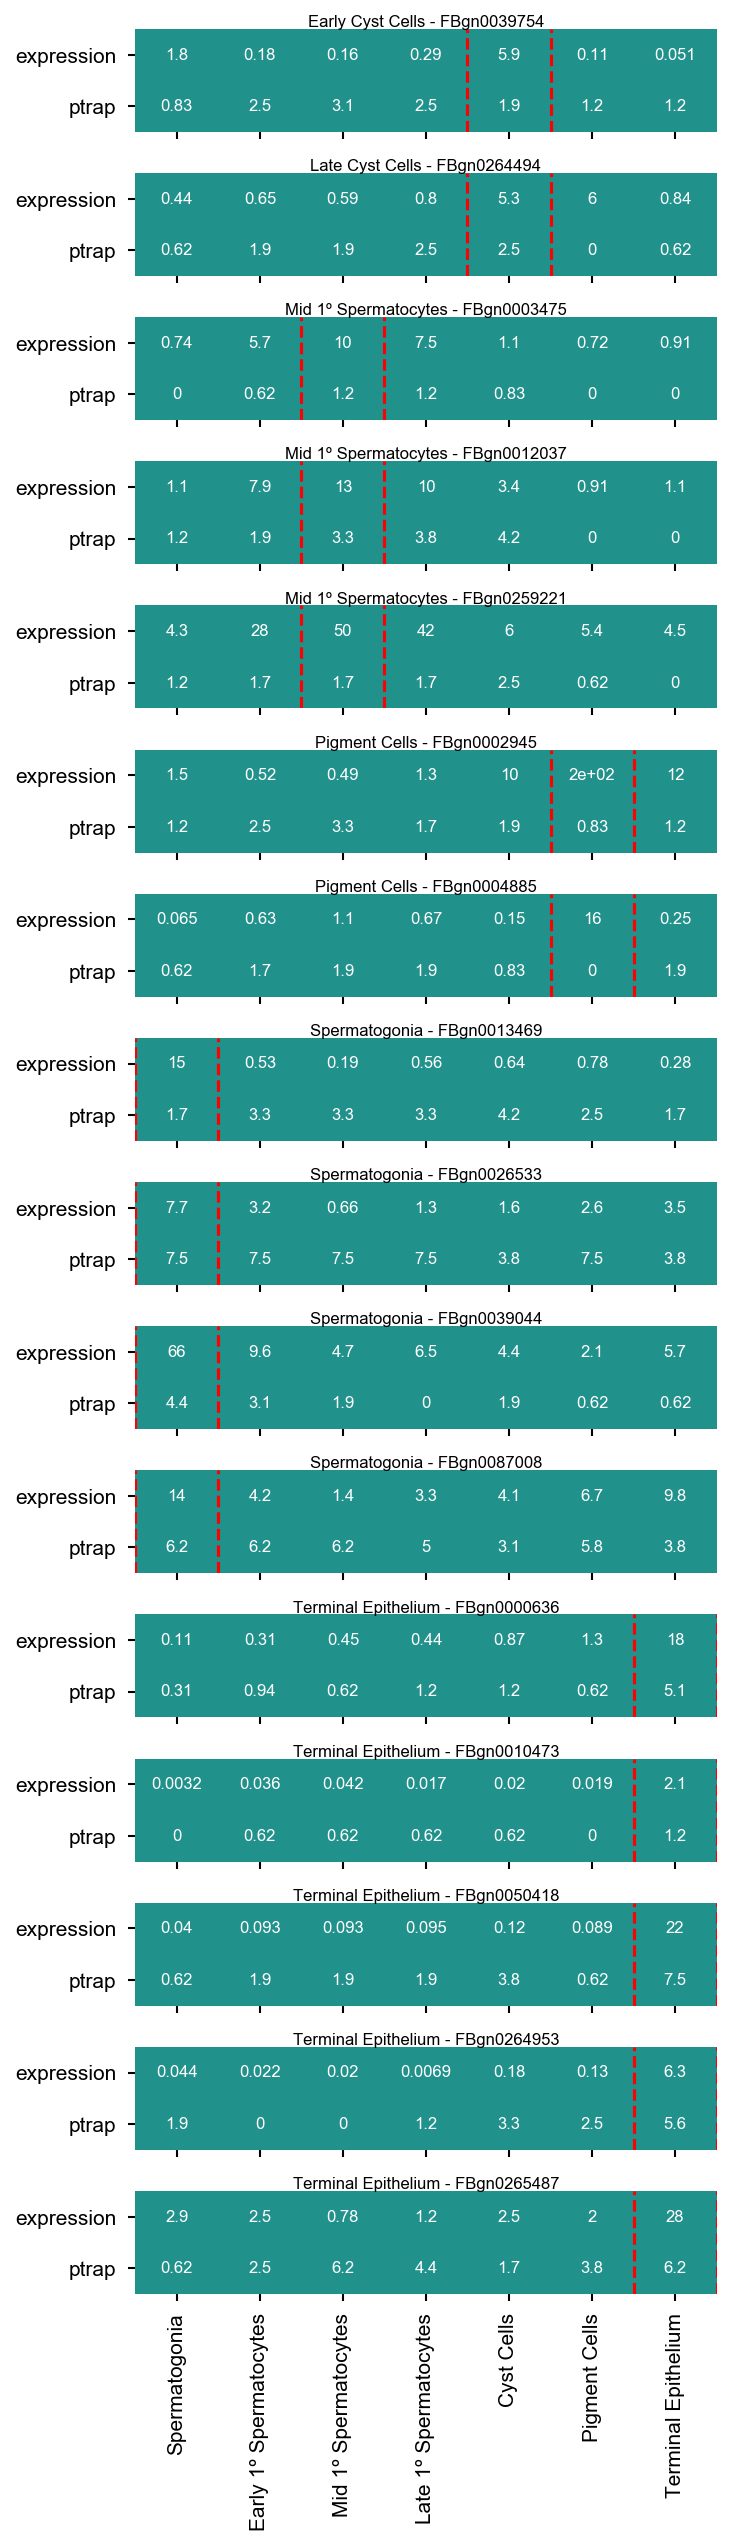

In [8]:
fig, axes = plt.subplots(16, 1, figsize=(5, 20), gridspec_kw=dict(hspace=.4), sharex=True)
for ax, (g, dd) in zip(axes, single_biomarkers_w_ranks.groupby(['cluster', 'FBgn'])):
    _ptrap = ptrap.reindex(dd.index)
    _ptrap['source'] = 'ptrap'
    _ptrap.set_index('source', append=True, inplace=True)

    _exp = _tpm.reindex(dd.index)
    _exp['source'] = 'expression'
    _exp.set_index('source', append=True, inplace=True)

    _dat = pd.concat([_exp, _ptrap])
    _dat.sort_index(inplace=True)
    _dat.index = _dat.index.droplevel('FBgn')
    plot_singles(ax, g, _dat, remove_color=True)

## Quartile Scaling

As per our last meeting we decided to try using quartile mapping for scRNA-Seq expression data. 
* Used TPM normalized data
* Broke data into quartile bins [0.25, 0.5, 0.75, 1]
* If TPM was 0, set bin label to 0
* This was exported and sent to Miriam as well

In [9]:
_tpm_quant = _tpm.apply(partial(pd.qcut, q=[0, .25, .5, .75, 1], labels=[.25, .5, .75, 1]), axis=1)
_tpm_quant[_tpm == 0] = 0
_tpm_quant.to_csv('../output/notebook/2018-11-20_ptrap_genes_tpm_quartiles.tsv', sep='\t')
_tpm_quant

,Spermatogonia,Early 1º Spermatocytes,Mid 1º Spermatocytes,Late 1º Spermatocytes,Cyst Cells,Pigment Cells,Terminal Epithelium
FBgn,,,,,,,
FBgn0000416,0.25,0.50,0.25,0.50,1.00,1.00,0.75
FBgn0000636,0.25,0.25,0.50,0.50,0.75,1.00,1.00
FBgn0002945,0.50,0.25,0.25,0.50,0.75,1.00,1.00
FBgn0003475,0.25,0.75,1.00,1.00,0.50,0.25,0.50
FBgn0004885,0.25,0.50,1.00,0.75,0.25,1.00,0.50
FBgn0010473,0.25,0.75,1.00,0.25,0.50,0.50,1.00
FBgn0011206,0.50,0.75,1.00,1.00,0.50,0.25,0.25
FBgn0011725,0.25,0.75,1.00,1.00,0.50,0.50,0.25
FBgn0012037,0.50,0.75,1.00,1.00,0.50,0.25,0.25


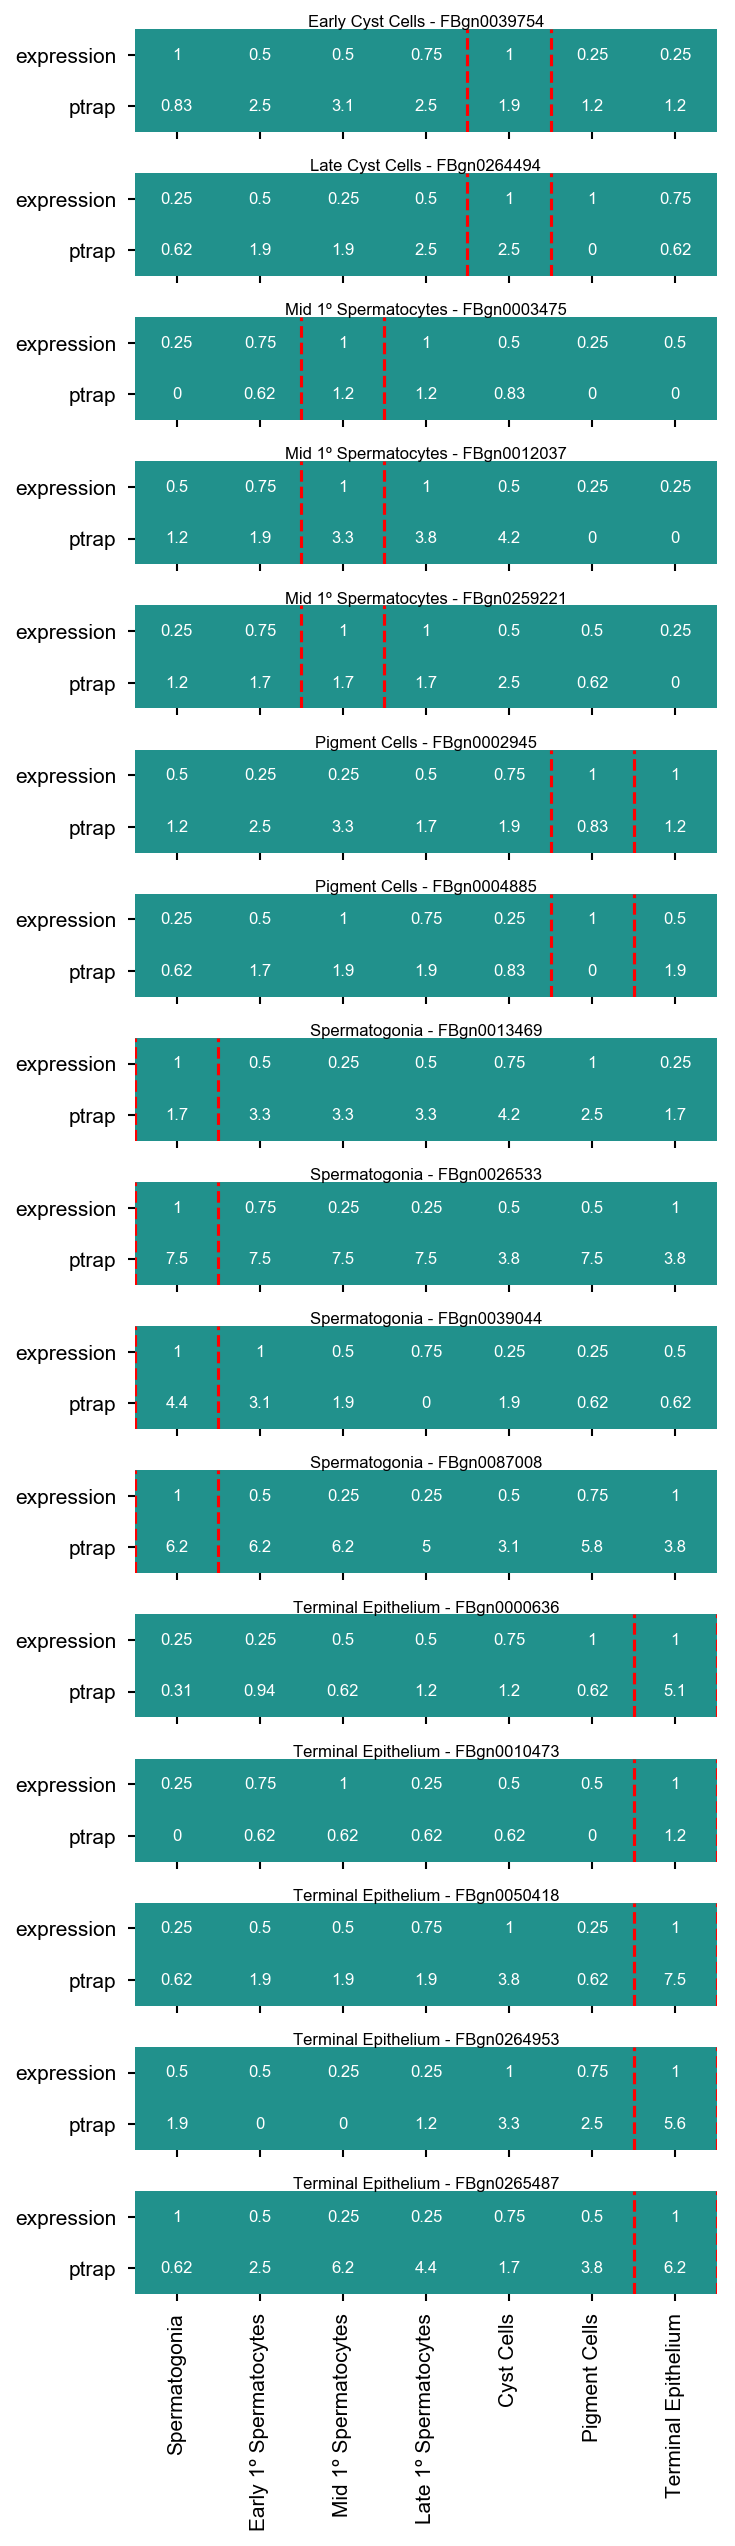

In [10]:
fig, axes = plt.subplots(16, 1, figsize=(5, 20), gridspec_kw=dict(hspace=.4), sharex=True)
for ax, (g, dd) in zip(axes, single_biomarkers_w_ranks.groupby(['cluster', 'FBgn'])):
    _ptrap = ptrap.reindex(dd.index)
    _ptrap['source'] = 'ptrap'
    _ptrap.set_index('source', append=True, inplace=True)

    _exp = _tpm_quant.reindex(dd.index)
    _exp['source'] = 'expression'
    _exp.set_index('source', append=True, inplace=True)

    _dat = pd.concat([_exp, _ptrap])
    _dat.sort_index(inplace=True)
    _dat.index = _dat.index.droplevel('FBgn')
    plot_singles(ax, g, _dat, remove_color=True)

## Min Max Scaling (convert to range 0 - 1)

Here i use a Min/Max scaler to put both expression and protein trap scores on a scale between 0-1.

Note: 0 does not mean that there was no expression, but means it was the minimum. Refer to "No Scaling" to get an idea of which ones are really 0.

In [11]:
# Use min/max scaling to put everything on a scale from 0 - 1
def scaler(x):
    _min = x.min()
    _max = x.max()
    return x.subtract(_min, axis='index').div(_max - _min, axis='index')

ptrap_min_max = ptrap.apply(scaler, axis=1)
tpm_min_max = _tpm.apply(scaler, axis=1)

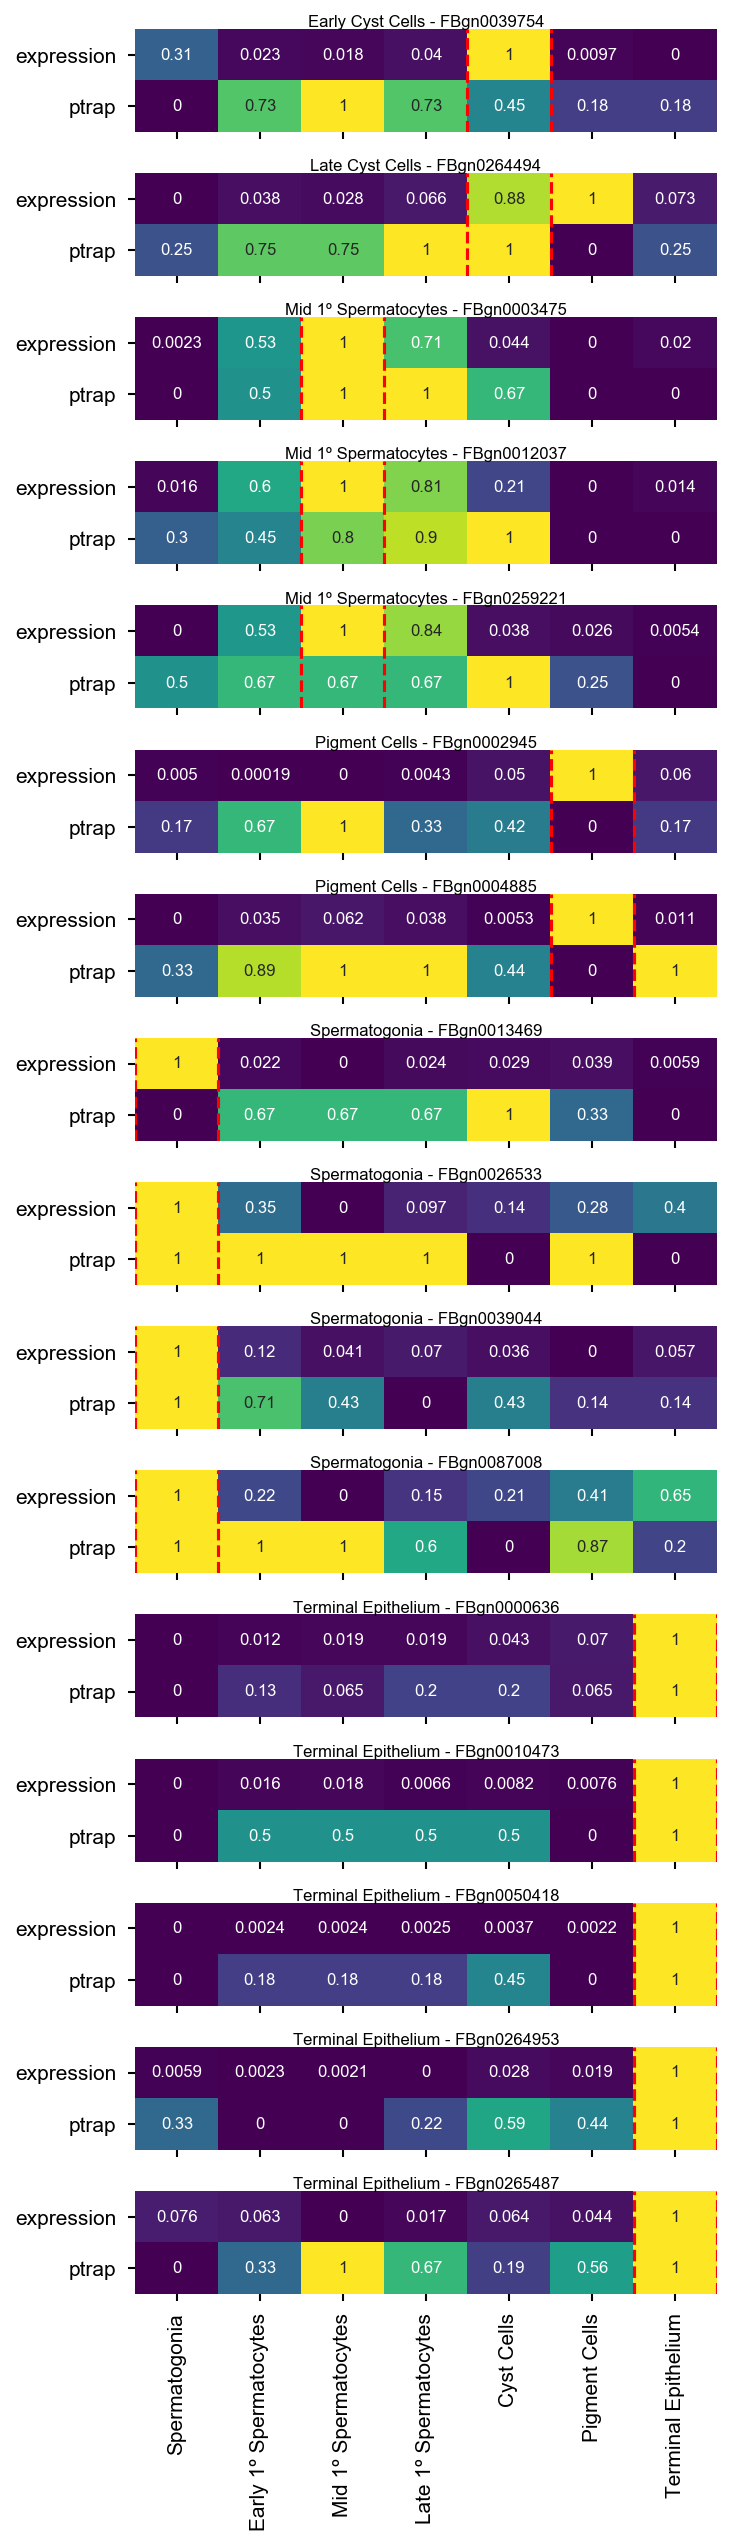

In [12]:
fig, axes = plt.subplots(16, 1, figsize=(5, 20), gridspec_kw=dict(hspace=.4), sharex=True)
for ax, (g, dd) in zip(axes, single_biomarkers_w_ranks.groupby(['cluster', 'FBgn'])):
    _ptrap = ptrap_min_max.reindex(dd.index)
    _ptrap['source'] = 'ptrap'
    _ptrap.set_index('source', append=True, inplace=True)

    _exp = tpm_min_max.reindex(dd.index)
    _exp['source'] = 'expression'
    _exp.set_index('source', append=True, inplace=True)

    _dat = pd.concat([_exp, _ptrap])
    _dat.sort_index(inplace=True)
    _dat.index = _dat.index.droplevel('FBgn')
    plot_singles(ax, g, _dat)

# Multiple Cluster Protein Traps

There are a 15 protein traps that are found in multiple clusters. It is unclear if we should only focus on the cluster where the gene is ranked the best (lowest rank value) or should require all clusters to validate.

Plots are set-up the same as above, except each gene is plotted multiple marking the different clusters it belongs to.

In [13]:
def plot_multi(ax, g, dat, remove_color=False):
    if remove_color:
        sns.heatmap(dat, cmap='viridis', vmin=-100000000, vmax=100000000, yticklabels=True, xticklabels=True, annot=True, annot_kws=dict(fontsize=8), ax=ax, cbar=None)
    else:
        sns.heatmap(dat, cmap='viridis', yticklabels=True, xticklabels=True, annot=True, annot_kws=dict(fontsize=8), ax=ax, cbar=None)
    plt.setp(ax.get_yticklabels(), rotation=0);
    ax.set_title('{} - {}'.format(*g), fontsize=8, y=.9);
    ax.set_ylabel('')
    add_box((g[1], g[0]), ax)
   

In [14]:
# pull out ptraps found in multiple cluster
_sizes = biomarkers_w_ranks.groupby('FBgn').size()
multis = _sizes.index[_sizes > 1].tolist()
multi_biomarkers_w_ranks = biomarkers_w_ranks[biomarkers_w_ranks.index.isin(multis)]
multi_biomarkers_w_ranks = multi_biomarkers_w_ranks.sort_values(by=['p_val_adj', 'avg_logFC'])
_clus_count = multi_biomarkers_w_ranks.cluster.value_counts().to_frame()
_clus_count.columns = ['Number Protein Traps in multiple cluster']
display(_clus_count)
multi_biomarkers_w_ranks.sort_values(by=['gene_symbol', 'rank'])

,Number Protein Traps in multiple cluster
Spermatogonia,6
Early 1º Spermatocytes,6
Terminal Epithelium,5
Early Cyst Cells,4
Late Cyst Cells,4
Pigment Cells,4
Mid 1º Spermatocytes,3
Late 1º Spermatocytes,2
Mid Cyst Cells,2


,gene_symbol,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,rank
FBgn,,,,,,,,
FBgn0026573,ADD1,4.063813e-210,0.343476,0.415,0.111,5.882775e-206,Early 1º Spermatocytes,218
FBgn0026573,ADD1,4.460005e-126,0.252031,0.358,0.118,6.456303e-122,Spermatogonia,1291
FBgn0032771,CG17349,7.907477e-54,0.594297,0.466,0.371,1.144686e-49,Late 1º Spermatocytes,236
FBgn0032771,CG17349,3.186443e-180,0.650788,0.662,0.347,4.612696e-176,Mid 1º Spermatocytes,331
FBgn0032771,CG17349,5.748635e-116,0.385392,0.705,0.348,8.321723e-112,Early 1º Spermatocytes,929
FBgn0034282,Mapmodulin,0.000000e+00,0.941398,0.908,0.452,0.000000e+00,Spermatogonia,371
FBgn0034282,Mapmodulin,7.257455e-20,0.277536,0.608,0.489,1.050589e-15,Terminal Epithelium,536
FBgn0262519,Mi-2,0.000000e+00,0.564454,0.609,0.169,0.000000e+00,Spermatogonia,181
FBgn0262519,Mi-2,6.951647e-07,0.256541,0.258,0.209,1.006320e-02,Terminal Epithelium,638


## No Scaling

Here I just use TPM normalized read counts and protein trap scores without any kind of scaling.

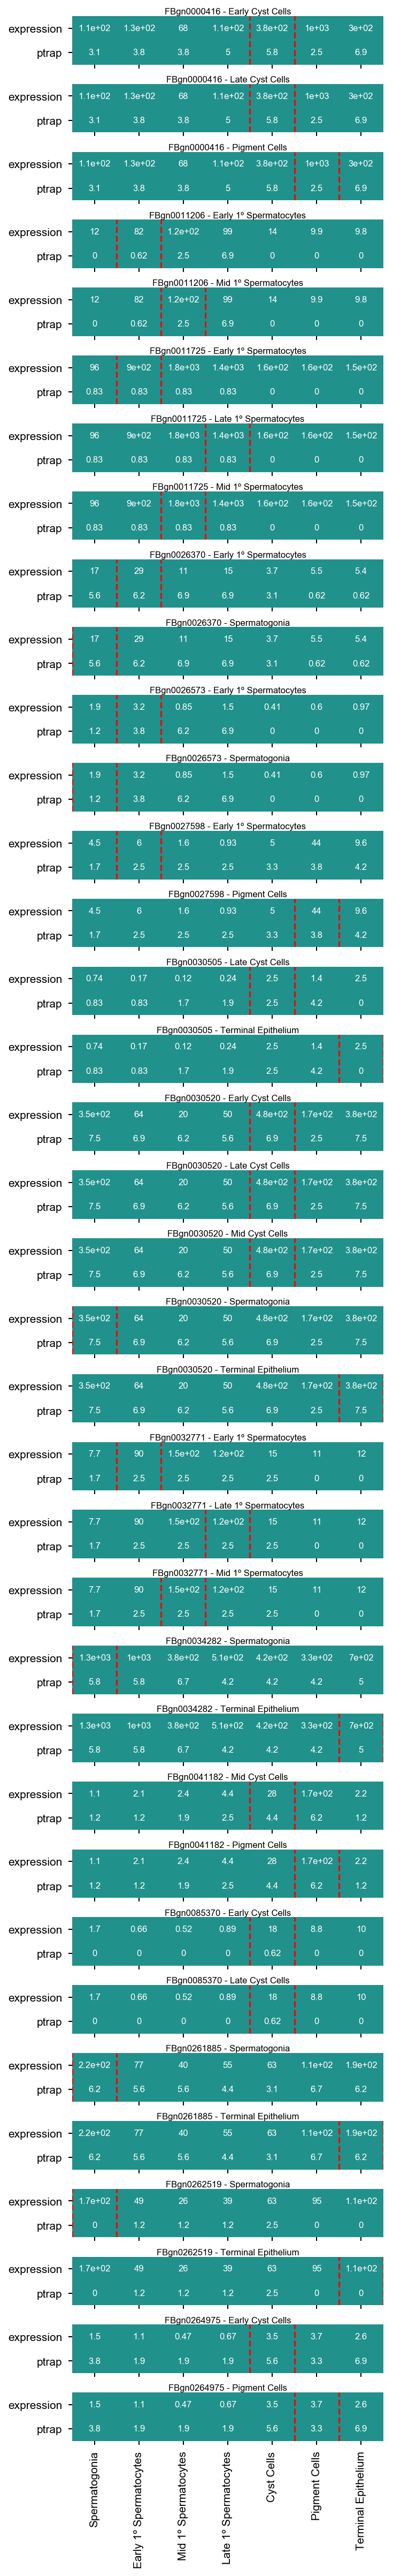

In [15]:
fig, axes = plt.subplots(36, 1, figsize=(5, 40), gridspec_kw=dict(hspace=.4), sharex=True)
for ax, (g, dd) in zip(axes, multi_biomarkers_w_ranks.groupby(['FBgn', 'cluster'])):
    _ptrap = ptrap.reindex(dd.index)
    _ptrap['source'] = 'ptrap'
    _ptrap.set_index('source', append=True, inplace=True)

    _exp = _tpm.reindex(dd.index)
    _exp['source'] = 'expression'
    _exp.set_index('source', append=True, inplace=True)

    _dat = pd.concat([_exp, _ptrap])
    _dat.sort_index(inplace=True)
    _dat.index = _dat.index.droplevel('FBgn')
    plot_multi(ax, g, _dat, remove_color=True)

## Quartile Scaling

As per our last meeting we decided to try using quartile mapping for scRNA-Seq expression data. 
* Used TPM normalized data
* Broke data into quartile bins [0.25, 0.5, 0.75, 1]
* If TPM was 0, set bin label to 0
* This was exported and sent to Miriam as well

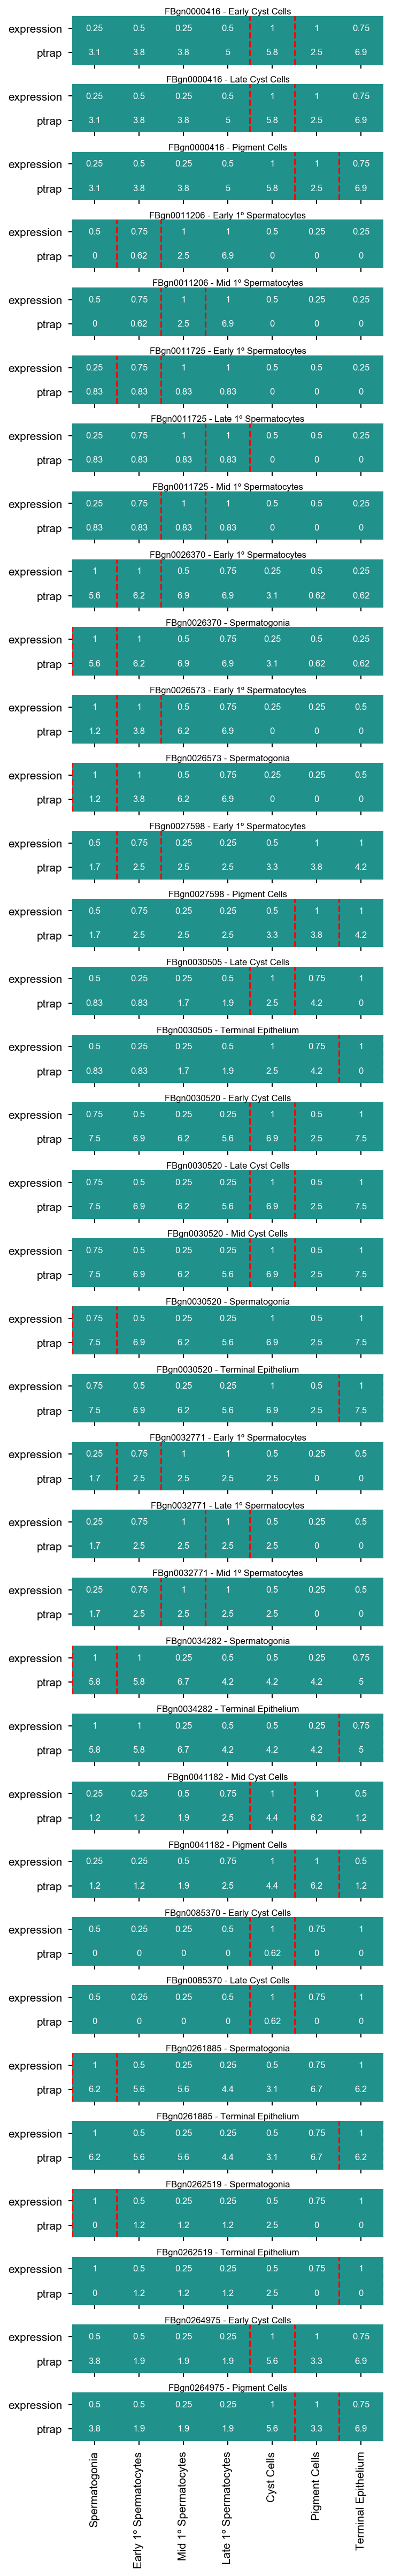

In [16]:
fig, axes = plt.subplots(36, 1, figsize=(5, 40), gridspec_kw=dict(hspace=.4), sharex=True)
for ax, (g, dd) in zip(axes, multi_biomarkers_w_ranks.groupby(['FBgn', 'cluster'])):
    _ptrap = ptrap.reindex(dd.index)
    _ptrap['source'] = 'ptrap'
    _ptrap.set_index('source', append=True, inplace=True)

    _exp = _tpm_quant.reindex(dd.index)
    _exp['source'] = 'expression'
    _exp.set_index('source', append=True, inplace=True)

    _dat = pd.concat([_exp, _ptrap])
    _dat.sort_index(inplace=True)
    _dat.index = _dat.index.droplevel('FBgn')
    plot_multi(ax, g, _dat, remove_color=True)

## Min Max Scaling (convert to range 0 - 1)

Here i use a Min/Max scaler to put both expression and protein trap scores on a scale between 0-1.

Note: 0 does not mean that there was no expression, but means it was the minimum. Refer to "No Scaling" to get an idea of which ones are really 0.

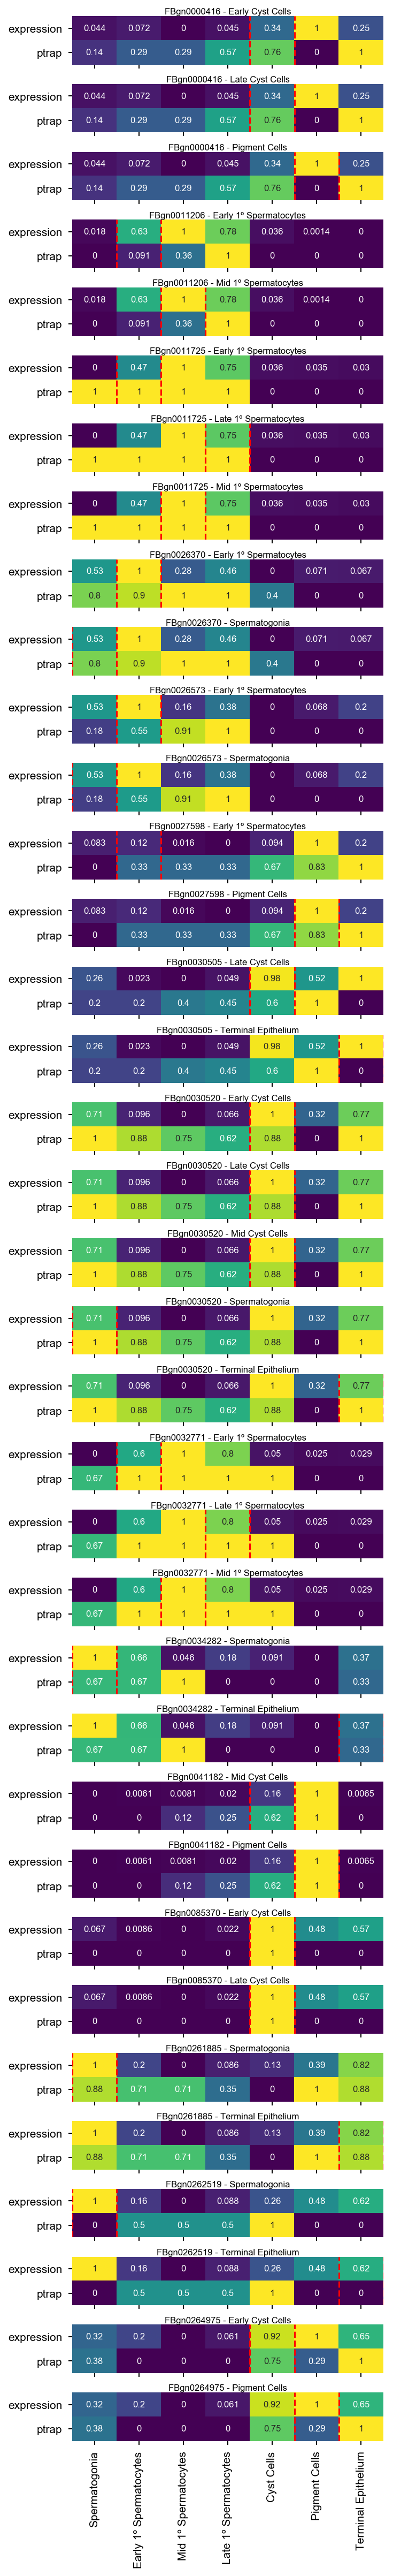

In [17]:
fig, axes = plt.subplots(36, 1, figsize=(5, 40), gridspec_kw=dict(hspace=.4), sharex=True)
for ax, (g, dd) in zip(axes, multi_biomarkers_w_ranks.groupby(['FBgn', 'cluster'])):
    _ptrap = ptrap_min_max.reindex(dd.index)
    _ptrap['source'] = 'ptrap'
    _ptrap.set_index('source', append=True, inplace=True)

    _exp = tpm_min_max.reindex(dd.index)
    _exp['source'] = 'expression'
    _exp.set_index('source', append=True, inplace=True)

    _dat = pd.concat([_exp, _ptrap])
    _dat.sort_index(inplace=True)
    _dat.index = _dat.index.droplevel('FBgn')
    plot_multi(ax, g, _dat)